#### This notebook shows how to serve Qwen2VL models using a vLLM Docker container as the backend server - simply run the Docker command in your terminal to start. 

#### The notebook includes both sample test data and load testing examples, allowing you to evaluate the model's latency and throughput performance.


#### Deploying Huggingface model with vLLM Docker 

This is the official sample from vLLM using docker. This will download the model Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4 directly

https://docs.vllm.ai/en/v0.5.5/serving/deploying_with_docker.html

In [ ]:
# Open the terminal and run the docker run command
docker run --runtime nvidia --gpus all \
    -v ~/.cache/huggingface:/root/.cache/huggingface \
    -p 8000:8000 \
    --ipc=host \
    vllm/vllm-openai:v0.6.3  \
    --model Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4 \
    --max-model-len 8192

INFO 11-18 04:21:11 metrics.py:345] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.

INFO 11-18 04:22:13 metrics.py:345] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 44.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 3.9%, CPU KV cache usage: 0.0%.

#### Deploying fine-tuned model with vLLM Docker 

In [1]:
# copy the model from s3
!aws s3 cp s3://sagemaker-lifecycle-b4d30f60/data/fsx/ubuntu/fine-tune-qwen2-vl-with-llama-factory/models/qwen2_vl_7b_pissa_qlora_128_fintabnet_en_awq_int4/ ./qwen2 --recursive

download: s3://sagemaker-lifecycle-b4d30f60/data/fsx/ubuntu/fine-tune-qwen2-vl-with-llama-factory/models/qwen2_vl_7b_pissa_qlora_128_fintabnet_en_awq_int4/added_tokens.json to qwen2/added_tokens.json
download: s3://sagemaker-lifecycle-b4d30f60/data/fsx/ubuntu/fine-tune-qwen2-vl-with-llama-factory/models/qwen2_vl_7b_pissa_qlora_128_fintabnet_en_awq_int4/generation_config.json to qwen2/generation_config.json
download: s3://sagemaker-lifecycle-b4d30f60/data/fsx/ubuntu/fine-tune-qwen2-vl-with-llama-factory/models/qwen2_vl_7b_pissa_qlora_128_fintabnet_en_awq_int4/chat_template.json to qwen2/chat_template.json
download: s3://sagemaker-lifecycle-b4d30f60/data/fsx/ubuntu/fine-tune-qwen2-vl-with-llama-factory/models/qwen2_vl_7b_pissa_qlora_128_fintabnet_en_awq_int4/config.json to qwen2/config.json
download: s3://sagemaker-lifecycle-b4d30f60/data/fsx/ubuntu/fine-tune-qwen2-vl-with-llama-factory/models/qwen2_vl_7b_pissa_qlora_128_fintabnet_en_awq_int4/merges.txt to qwen2/merges.txt
download: s3:/

In [ ]:
docker run --runtime nvidia --gpus all \
    -v /home/ec2-user/SageMaker/awq/qwen2/:/opt/ml/Qwen2-VL-7B-Instruct-AWQ-Int4 \
    -p 8000:8000 \
    --ipc=host \
    vllm/vllm-openai:v0.6.4  \
    --model /opt/ml/Qwen2-VL-7B-Instruct-AWQ-Int4 \
    --dtype float16 \
    --max-model-len 8192

INFO:     Started server process [1] <br>
INFO:     Waiting for application startup. <br>
INFO:     Application startup complete.<br>
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit) <br>
INFO 11-20 18:27:37 metrics.py:449] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%. <br>
INFO 11-20 18:27:47 metrics.py:449] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.<br>
INFO 11-20 18:29:10 engine.py:267] Added request chatcmpl-c5b3b13f4a794d7099eaed6a6c377318. <br>
INFO 11-20 18:29:14 metrics.py:449] Avg prompt throughput: 319.1 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 2.2%, CPU KV cache usage: 0.0%. <br>
INFO 11-20 18:29:34 metrics.py:449] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 32.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 3.0%, CPU KV cache usage: 0.0%.<br>
INFO:     172.17.0.1:55380 - "POST /v1/chat/completions HTTP/1.1" 200 OK<br>

### Testing the inference

In [5]:
!pip install OpenAI

In [13]:
from PIL import Image

test_image = "income_statement.jpg"
raw_image = Image.open(test_image).convert('RGB')

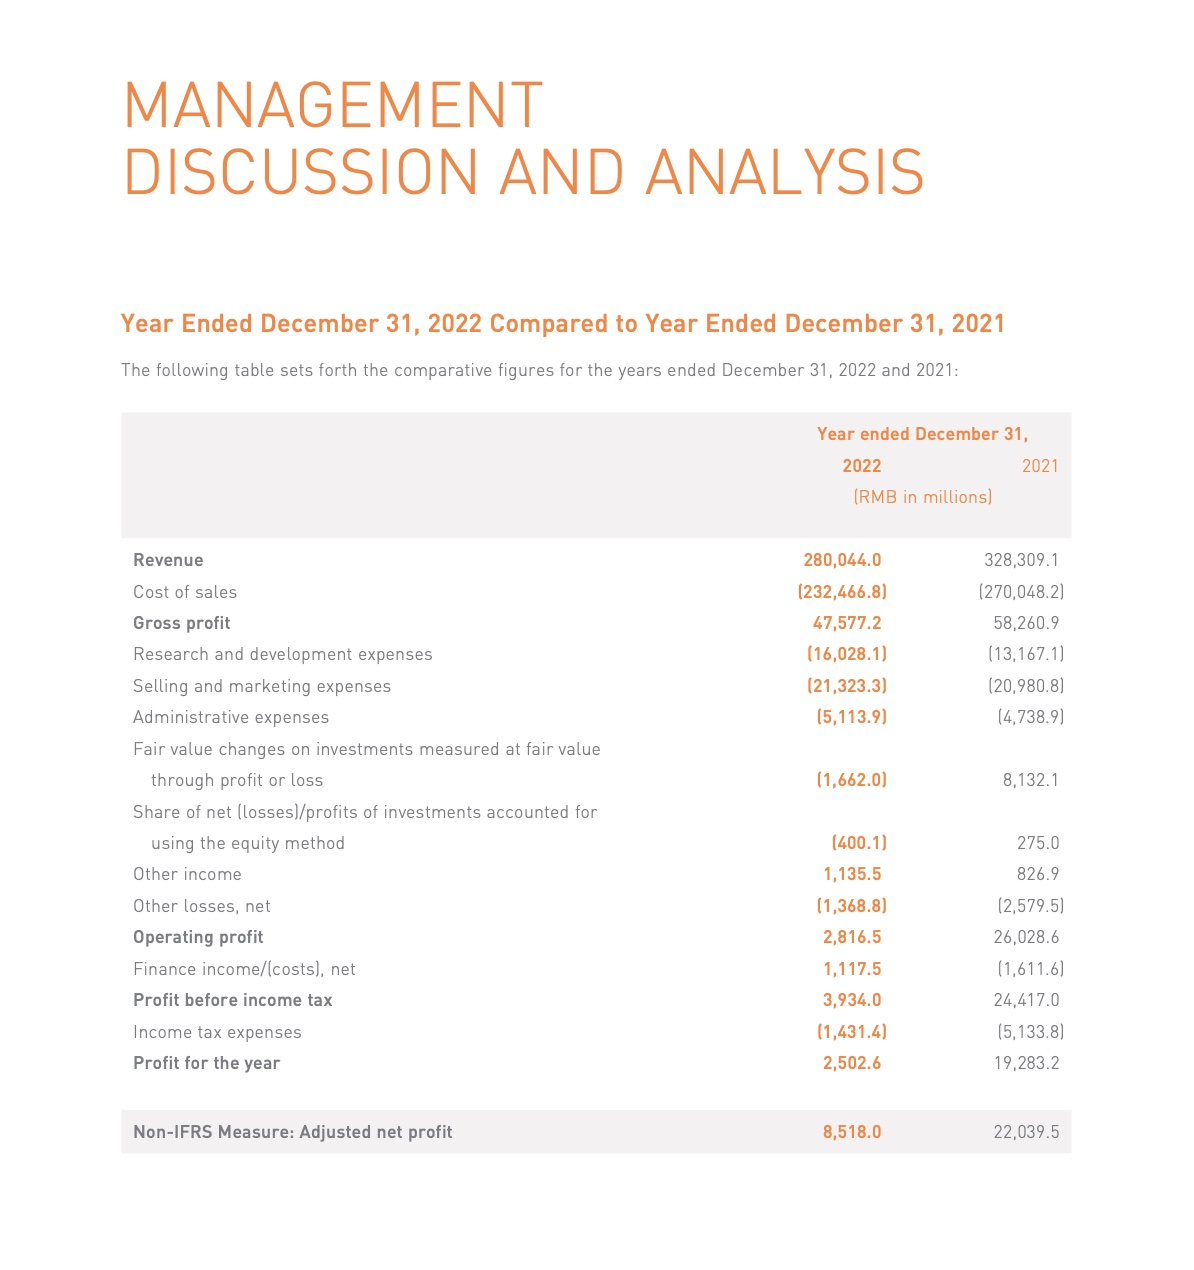

In [14]:
display(raw_image)

In [15]:
from openai import OpenAI

# Modify OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:8000/v1"
client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)

In [27]:
import requests
import json
import base64


def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Replace with your image path
test_image = "income_statement.jpg"
base64_image = encode_image(test_image)

url = "http://localhost:8000/invocations"
headers = {"Content-Type": "application/json"}

request = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Please generate accurate HTML code that represents the table structure shown in input image, including any merged cells."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    "max_tokens": 4096
}

completion = client.chat.completions.create(model="/opt/ml/Qwen2-VL-7B-Instruct-AWQ-Int4",
                                       messages=request["messages"],
                                       max_tokens=request["max_tokens"])


print("Completion result:", completion)

Completion result: ChatCompletion(id='chatcmpl-c3947233962b4216b54a73783f8afca3', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='<html>\n<body>\n<table>\n<tr>\n<td colspan="2">MANAGEMENT DISCUSSION AND ANALYSIS</td>\n<td></td>\n</tr>\n<tr>\n<td colspan="2">Year Ended December 31, 2022 Compared to Year Ended December 31, 2021</td>\n<td></td>\n</tr>\n<tr>\n<td colspan="2">The following table sets forth the comparative figures for the years ended December 31, 2022 and 2021:</td>\n<td></td>\n</tr>\n<tr>\n<td></td>\n<td colspan="2">Year ended December 31,</td>\n</tr>\n<tr>\n<td></td>\n<td>2022</td>\n<td>2021</td>\n</tr>\n<tr>\n<td></td>\n<td colspan="2">(RMB in millions)</td>\n</tr>\n<tr>\n<td>Revenue</td>\n<td>280,044.0</td>\n<td>328,309.1</td>\n</tr>\n<tr>\n<td>Cost of sales</td>\n<td>(232,466.8)</td>\n<td>(270,048.2)</td>\n</tr>\n<tr>\n<td>Gross profit</td>\n<td>47,577.2</td>\n<td>58,260.9</td>\n</tr>\n<tr>\n<td>Research and developme

#### Quick loadtesting for throughput and latency

In [24]:
!pip install locust

In [28]:
%%writefile locustfile.py

from locust import User, task, between
import logging
import json
from PIL import Image
import base64
import time

from openai import OpenAI

# Modify OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:8000/v1"
client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)


# Prepare the image and inputs
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Replace with your image path
test_image = "income_statement.jpg"
base64_image = encode_image(test_image)

url = "http://localhost:8000/invocations"
headers = {"Content-Type": "application/json"}


try:
    raw_image = Image.open(test_image).convert('RGB')
    base64_image = encode_image(test_image)
except Exception as e:
    logging.error(f"Image preparation failed: {str(e)}")
    raise

request = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Please generate accurate HTML code that represents the table structure shown in input image, including any merged cells."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    "max_tokens": 4096
}

class LLMUser(User):

    @task
    def generation(self):
        try:
            with self.environment.events.request.measure("[Send]", "Prompt"):
                completion = client.chat.completions.create(model="/opt/ml/Qwen2-VL-7B-Instruct-AWQ-Int4",
                                                       messages=request["messages"],
                                                       max_tokens=request["max_tokens"])
                logging.info(completion)
            
        except Exception as e:
            logging.error(f"Generation failed: {str(e)}")
            self.environment.events.request_failure.fire(
                request_type="Prompt",
                name="[Send]",
                response_time=0,
                exception=e
            )
            time.sleep(1)  # Add small delay after errors

Overwriting locustfile.py


### We aim to find an optimal balance between latency and throughput. While increasing throughput leads to higher token generation rates (tokens/second), it also increases the initial response time. This creates a tradeoff between processing speed and response time that needs to be carefully managed.



Example of vLLM server log 

INFO 11-20 18:48:50 metrics.py:449] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 203.0 tokens/s, Running: 10 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 25.8%, CPU KV cache usage: 0.0%.<br>
INFO 11-20 18:48:55 metrics.py:449] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 200.9 tokens/s, Running: 10 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 26.9%, CPU KV cache usage: 0.0%.<br>
INFO 11-20 18:49:01 metrics.py:449] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 199.1 tokens/s, Running: 10 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 27.9%, CPU KV cache usage: 0.0%.<br>

| Name | Request Count | Failure Count | Median Response Time | Average Response Time | Min Response Time | Max Response Time | Average Content Size | Requests/s |
|------|---------------|---------------|---------------------|---------------------|------------------|------------------|-------------------|------------|
| Prompt | 25 | 0 | 80,000.00 | 81,421.49 | 63,102.21 | 109,871.76 | 0.0 | 0.105 |

In [31]:
!locust --headless --users 10 --spawn-rate 10 --run-time 240 --csv ./benchmark_metric/benchmark_u10

[2024-11-21 02:47:59,526] ip-172-16-67-62/INFO/locust.main: Starting Locust 2.32.3
[2024-11-21 02:47:59,527] ip-172-16-67-62/INFO/locust.main: Run time limit set to 240 seconds
Type     Name  # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
         Aggregated       0     0(0.00%) |      0       0       0      0 |    0.00        0.00

[2024-11-21 02:47:59,528] ip-172-16-67-62/INFO/locust.runners: Ramping to 10 users at a rate of 10.00 per second
[2024-11-21 02:47:59,528] ip-172-16-67-62/INFO/locust.runners: All users spawned: {"LLMUser": 10} (10 total users)
Type     Name  # reqs      # fails |    Avg     Min     Max    Med |   req/s  failures/s
--------||-------|-------------|-------|-------|-------|-------|--------|-----------
--------||-------|-------------|-------|-------|-------|-------|--